In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [0]:
from statsmodels.tsa.stattools import adfuller

# Feature Light as univariate framework

In [0]:
url = 'https://raw.githubusercontent.com/ZioTrib/dm2proj/master/datatraining.csv'
df = pd.read_csv(url) 

url_test1 = 'https://raw.githubusercontent.com/ZioTrib/dm2proj/master/datatest.csv'
df_test1 =pd.read_csv(url_test1)

url_test2 = 'https://raw.githubusercontent.com/ZioTrib/dm2proj/master/datatest2.csv'
df_test2 =pd.read_csv(url_test2)

In [0]:
df['date'] = pd.to_datetime(df['date'])
df_test1['date'] = pd.to_datetime(df_test1['date'])
df_test2['date'] = pd.to_datetime(df_test2['date'])

In [0]:
df = df.set_index(['date'])
df_test1 = df_test1.set_index(['date'])
df_test2 = df_test2.set_index(['date'])

In [0]:
df = df[['Light','Occupancy']]
df

,Light,Occupancy
date,,
2015-02-04 17:51:00,426.0,1
2015-02-04 17:51:59,429.5,1
2015-02-04 17:53:00,426.0,1
2015-02-04 17:54:00,426.0,1
2015-02-04 17:55:00,426.0,1
...,...,...
2015-02-10 09:29:00,433.0,1
2015-02-10 09:29:59,433.0,1
2015-02-10 09:30:59,433.0,1


In [0]:
df_test1 = df_test1[['Light','Occupancy']]
df_test1

,Light,Occupancy
date,,
2015-02-02 14:19:00,585.200000,1
2015-02-02 14:19:59,578.400000,1
2015-02-02 14:21:00,572.666667,1
2015-02-02 14:22:00,493.750000,1
2015-02-02 14:23:00,488.600000,1
...,...,...
2015-02-04 10:38:59,808.000000,1
2015-02-04 10:40:00,809.800000,1
2015-02-04 10:40:59,817.000000,1


In [0]:
df_test2 = df_test2[['Light','Occupancy']]
df_test2

,Light,Occupancy
date,,
2015-02-11 14:48:00,437.333333,1
2015-02-11 14:49:00,437.333333,1
2015-02-11 14:50:00,434.000000,1
2015-02-11 14:51:00,439.000000,1
2015-02-11 14:51:59,437.333333,1
...,...,...
2015-02-18 09:15:00,429.750000,1
2015-02-18 09:16:00,423.500000,1
2015-02-18 09:16:59,423.500000,1


### Noise

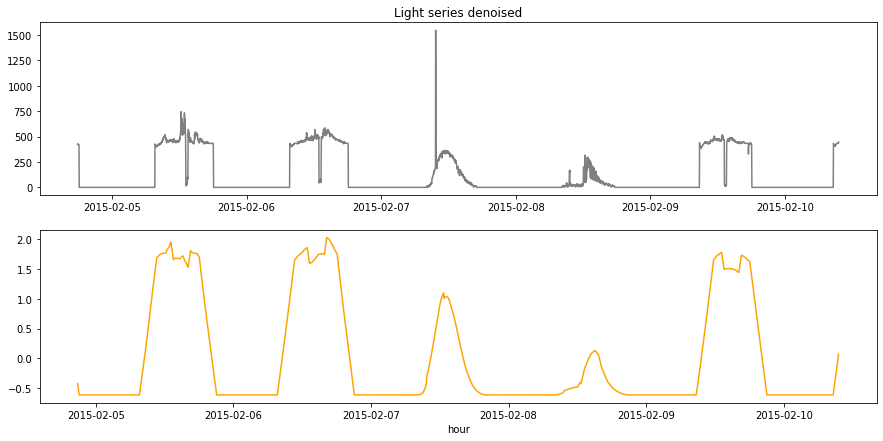

In [0]:
w = 180
plt.figure(figsize=(15,7))
plt.subplot(212)
df_denoised = ((df['Light']-df['Light'].mean())/df['Light'].std()).rolling(window=w).mean()
plt.plot(df_denoised, c = 'orange')
plt.xlabel('hour')

plt.subplot(211)
plt.plot(df['Light'], c = 'grey')

plt.title('Light series denoised')
plt.show()

#### Trend on Denoised

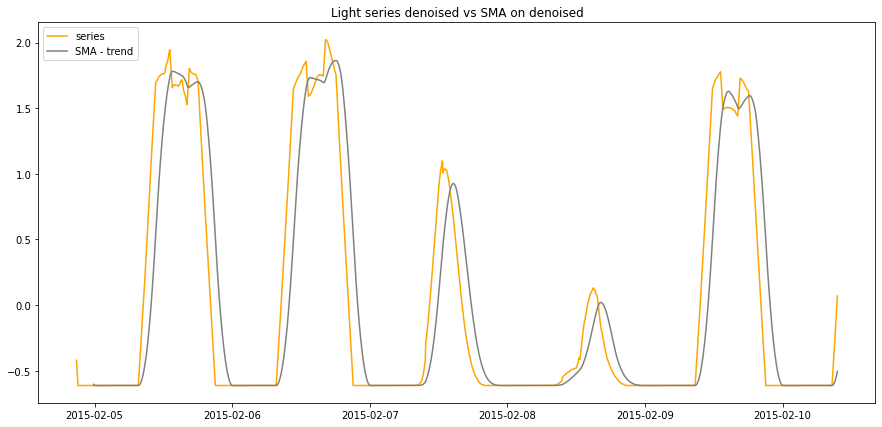

In [0]:
ts = df_denoised.loc['2015-02-04':'2015-02-10']
sma = ts.rolling(window = 180).mean()       #simple moving average
plt.figure(figsize=(15,7))
plt.plot(ts, c ='orange')
plt.plot(sma, c = 'grey')
plt.legend(['series','SMA - trend'], loc = 'upper left')  
plt.title('Light series denoised vs SMA on denoised') 
plt.show()

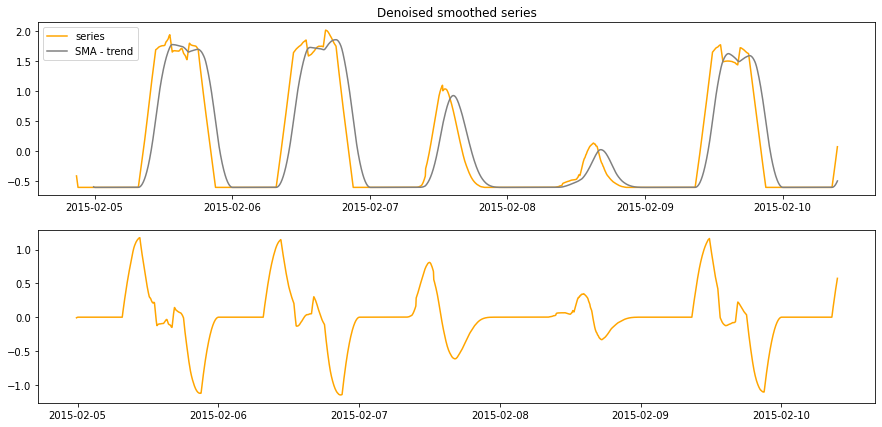

In [0]:
plt.figure(figsize=(15,7))
plt.subplot(211)
ts = df_denoised.loc['2015-02-04':'2015-02-10']
sma = ts.rolling(window = 180).mean()       #simple moving average
plt.plot(ts, c ='orange')
plt.plot(sma, c = 'grey')
plt.title('Denoised smoothed series')

plt.legend(['series','SMA - trend'], loc = 'upper left')   

plt.subplot(212)
ts_shift = ts - sma
plt.plot(ts_shift, c = 'orange')
plt.show()

In [0]:
dftest = adfuller(df_denoised.values[179:], autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -4.718377
p-value                           0.000078
#Lags Used                       31.000000
Number of Observations Used    7932.000000
Critical Value (1%)              -3.431175
Critical Value (5%)              -2.861904
Critical Value (10%)             -2.566964
dtype: float64


In [0]:
dftest = adfuller(ts_shift.values[358:], autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.714264e+00
p-value                        3.615284e-09
#Lags Used                     3.100000e+01
Number of Observations Used    7.753000e+03
Critical Value (1%)           -3.431194e+00
Critical Value (5%)           -2.861913e+00
Critical Value (10%)          -2.566968e+00
dtype: float64


# Data Preparation

In [0]:
# define a check stationarity function
def check_stationarity(timeseries,w):

    # Determine rolling statistics (moving averages and variance)
    rolmean = timeseries.rolling(window=w).mean()
    rolstd = timeseries.rolling(window=w).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15,7))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [0]:
## Origina ts

In [0]:
ts = df_denoised[179:]
ts_test = ((df_test2['Light']-df_test2['Light'].mean())/df_test2['Light'].std()).rolling(window=w).mean()
ts_test
ts

date
2015-02-04 20:50:00   -0.421368
2015-02-04 20:51:00   -0.433520
2015-02-04 20:51:59   -0.445772
2015-02-04 20:53:00   -0.457924
2015-02-04 20:54:00   -0.470075
                         ...   
2015-02-10 09:29:00    0.018333
2015-02-10 09:29:59    0.030685
2015-02-10 09:30:59    0.043036
2015-02-10 09:32:00    0.055388
2015-02-10 09:33:00    0.068139
Name: Light, Length: 7964, dtype: float64

In [0]:
index = pd.date_range(start=ts.index[0], end=ts.index[len(ts)-1], freq='min')

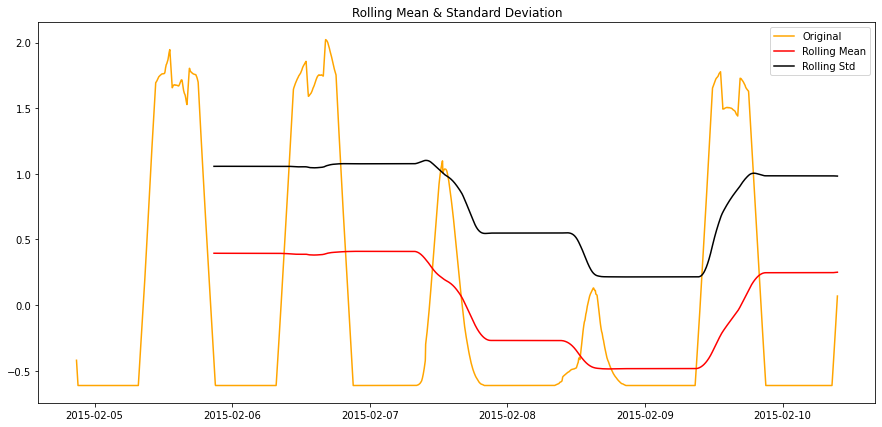

Results of Dickey-Fuller Test:
Test Statistic                   -4.718377
p-value                           0.000078
#Lags Used                       31.000000
Number of Observations Used    7932.000000
Critical Value (1%)              -3.431175
Critical Value (5%)              -2.861904
Critical Value (10%)             -2.566964
dtype: float64


In [0]:
check_stationarity(ts,1440)

#### Autocorrelation and Partial Autocorrelation

In [0]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


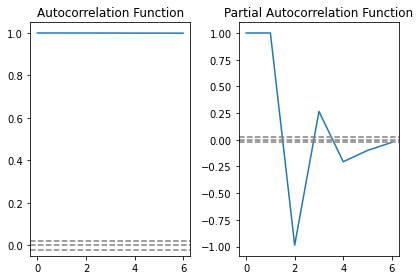

In [0]:
# ACF (autocorrelation function) and PACF (partial autocorrelation function) plots:
lag_acf = acf(ts, nlags=6)
lag_pacf = pacf(ts, nlags=6, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

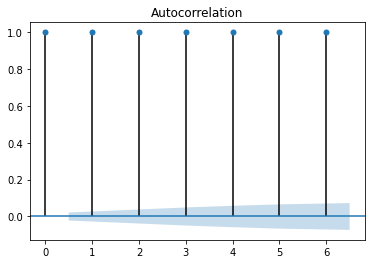

In [0]:
plot_acf(ts, lags=6)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


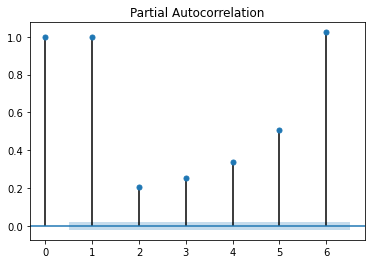

In [0]:
plot_pacf(ts, lags=6)
plt.show()

### Log Tranformation

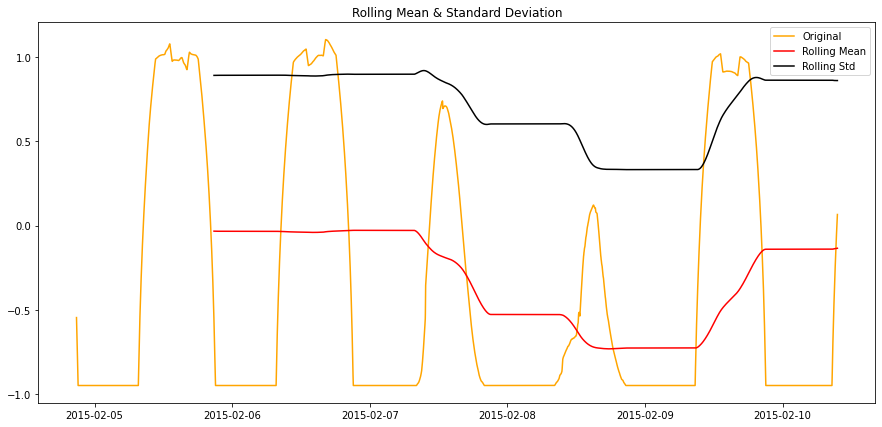

Results of Dickey-Fuller Test:
Test Statistic                   -3.654261
p-value                           0.004805
#Lags Used                       20.000000
Number of Observations Used    7943.000000
Critical Value (1%)              -3.431174
Critical Value (5%)              -2.861904
Critical Value (10%)             -2.566964
dtype: float64


In [0]:
ts_log = pd.Series(np.log(ts.values+1), index)
check_stationarity(ts_log,1440)


#### Autocorrelation and Partial Autocorrelation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


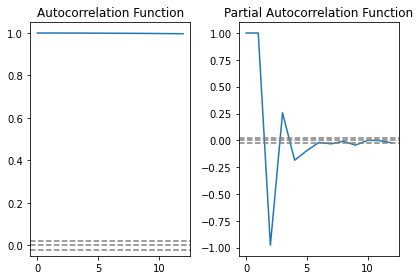

In [0]:
# ACF (autocorrelation function) and PACF (partial autocorrelation function) plots:
lag_acf = acf(ts_log, nlags=12)
lag_pacf = pacf(ts_log, nlags=12, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

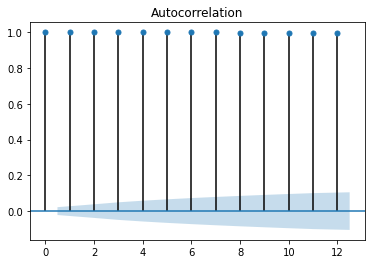

In [0]:
plot_acf(ts_log, lags=12)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


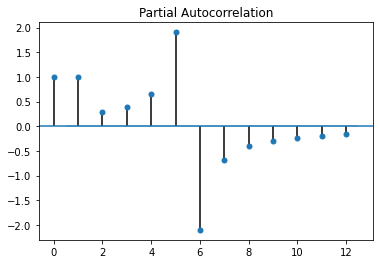

In [0]:
plot_pacf(ts_log, lags=12)
plt.show()

### Diff Tranformation

<Figure size 1080x504 with 0 Axes>

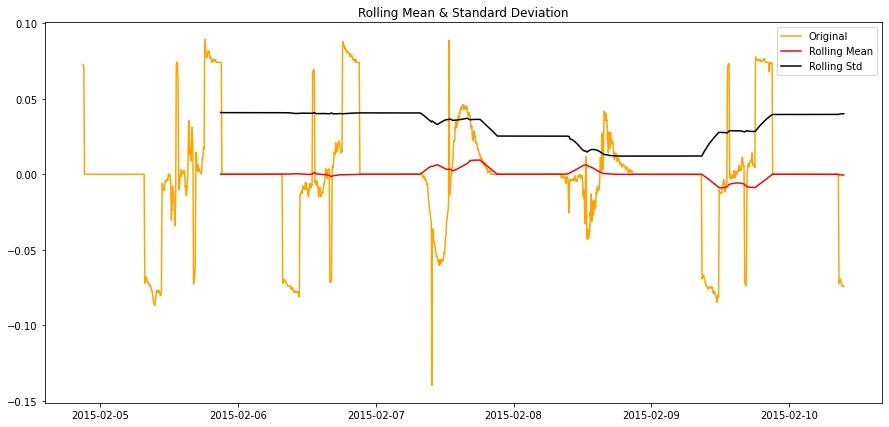

Results of Dickey-Fuller Test:
Test Statistic                   -4.634682
p-value                           0.000111
#Lags Used                       36.000000
Number of Observations Used    7921.000000
Critical Value (1%)              -3.431176
Critical Value (5%)              -2.861905
Critical Value (10%)             -2.566964
dtype: float64


In [0]:
plt.figure(figsize=(15,7))
ts_diff = pd.Series(ts[:-6].values - ts[6:].values, index=ts.index[6:])
check_stationarity(ts_diff,1440)

#### Autocorrelation and Partial Autocorrelation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


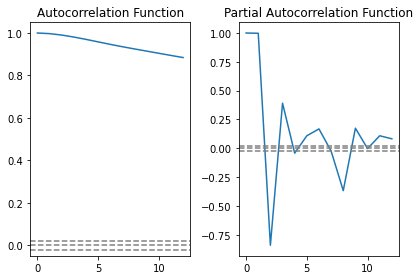

In [0]:
lag_acf = acf(ts_diff, nlags=12)
lag_pacf = pacf(ts_diff, nlags=12, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

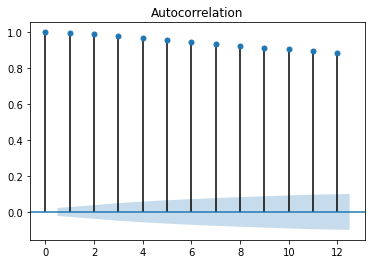

In [0]:
plot_acf(ts_diff, lags=12)
plt.show()

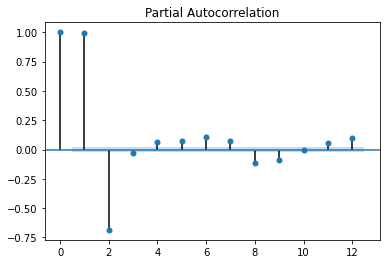

In [0]:
plot_pacf(ts_diff, lags=12)
plt.show()

### Log Mean Diff Tranformation

<Figure size 1080x504 with 0 Axes>

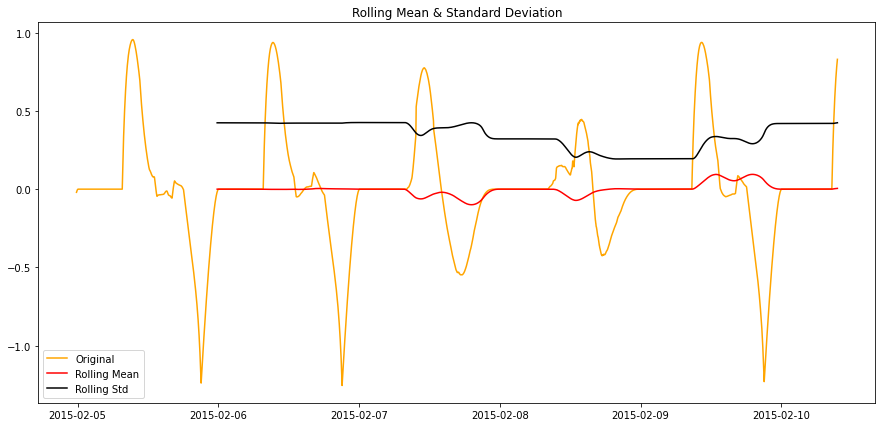

Results of Dickey-Fuller Test:
Test Statistic                   -5.252739
p-value                           0.000007
#Lags Used                       21.000000
Number of Observations Used    7763.000000
Critical Value (1%)              -3.431193
Critical Value (5%)              -2.861912
Critical Value (10%)             -2.566968
dtype: float64


In [0]:
plt.figure(figsize=(15,7))
window = 180
ts_log_mov_diff = pd.Series(ts_log - ts_log.rolling(window, center=False).mean(), index=ts_log.index)
check_stationarity(ts_log_mov_diff[179:],1440)

#### Autocorrelation and Partial Autocorrelation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


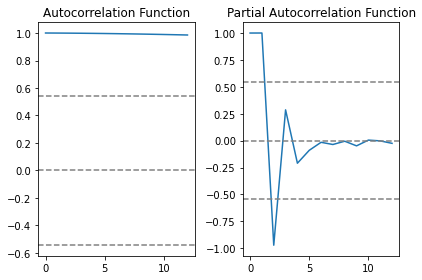

In [0]:
lag_acf = acf(ts_log_mov_diff.values[179:], nlags=12)
lag_pacf = pacf(ts_log_mov_diff[179:], nlags=12, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

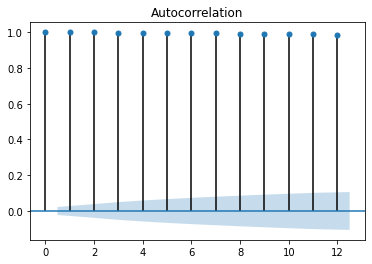

In [0]:
plot_acf(ts_log_mov_diff.values[179:], lags=12)
plt.show()

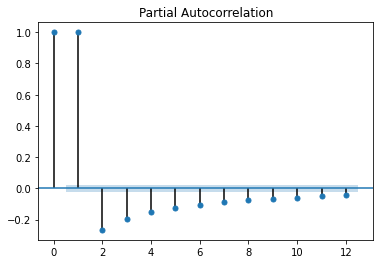

In [0]:
plot_pacf(ts_log_mov_diff.values[179:], lags=12)
plt.show()

# Decomposition

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [0]:
index = pd.date_range(start=ts.index[0], end=ts.index[len(ts)-1], freq='T')
ts = pd.Series(ts.values,index)
ts

2015-02-04 20:50:00   -0.421368
2015-02-04 20:51:00   -0.433520
2015-02-04 20:52:00   -0.445772
2015-02-04 20:53:00   -0.457924
2015-02-04 20:54:00   -0.470075
                         ...   
2015-02-10 09:29:00    0.018333
2015-02-10 09:30:00    0.030685
2015-02-10 09:31:00    0.043036
2015-02-10 09:32:00    0.055388
2015-02-10 09:33:00    0.068139
Freq: T, Length: 7964, dtype: float64

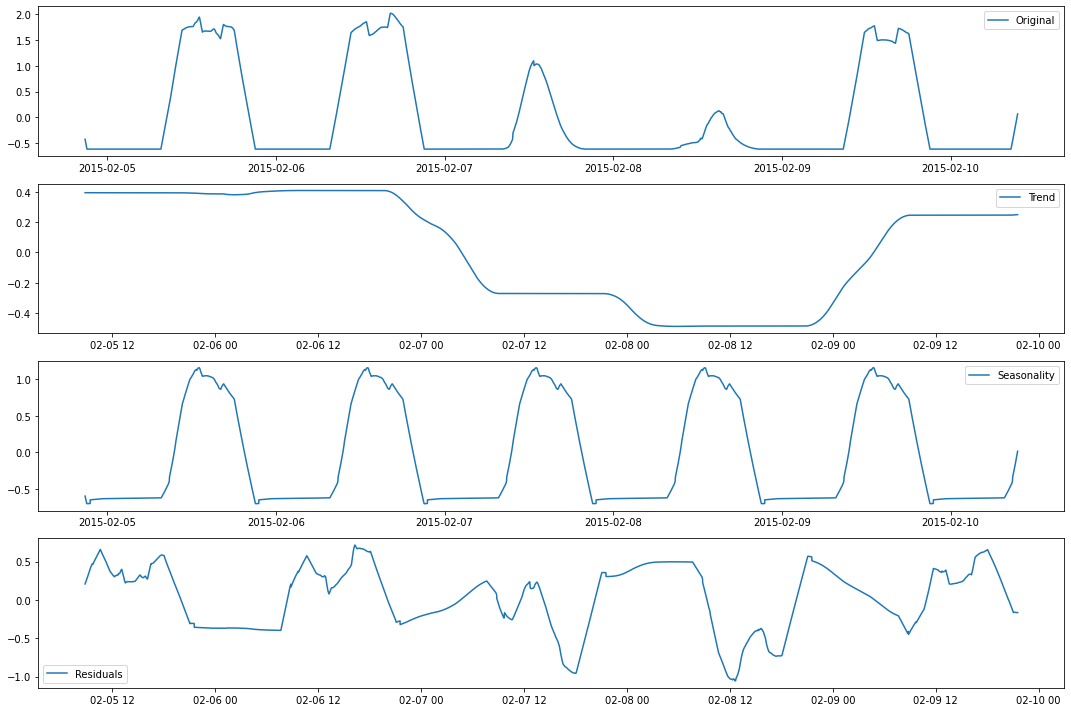

In [0]:
decomposition = sm.tsa.seasonal_decompose(ts,freq=1440)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize =(15,10))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

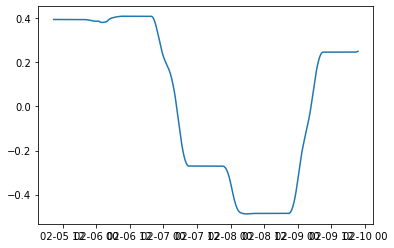

In [0]:
plt.plot(trend)

In [0]:
dftest = adfuller(residual.values[720:-720], autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.983917
p-value                           0.001497
#Lags Used                       10.000000
Number of Observations Used    6513.000000
Critical Value (1%)              -3.431354
Critical Value (5%)              -2.861984
Critical Value (10%)             -2.567006
dtype: float64


In [0]:
index = pd.date_range(start=ts_log_mov_diff.index[0], end=ts_log_mov_diff.index[len(ts)-1], freq='T')
ts_log_mov_diff = pd.Series(ts_log_mov_diff.values,index)
ts_log_mov_diff

2015-02-04 20:50:00         NaN
2015-02-04 20:51:00         NaN
2015-02-04 20:52:00         NaN
2015-02-04 20:53:00         NaN
2015-02-04 20:54:00         NaN
                         ...   
2015-02-10 09:29:00    0.803890
2015-02-10 09:30:00    0.810495
2015-02-10 09:31:00    0.816889
2015-02-10 09:32:00    0.823078
2015-02-10 09:33:00    0.829438
Freq: T, Length: 7964, dtype: float64

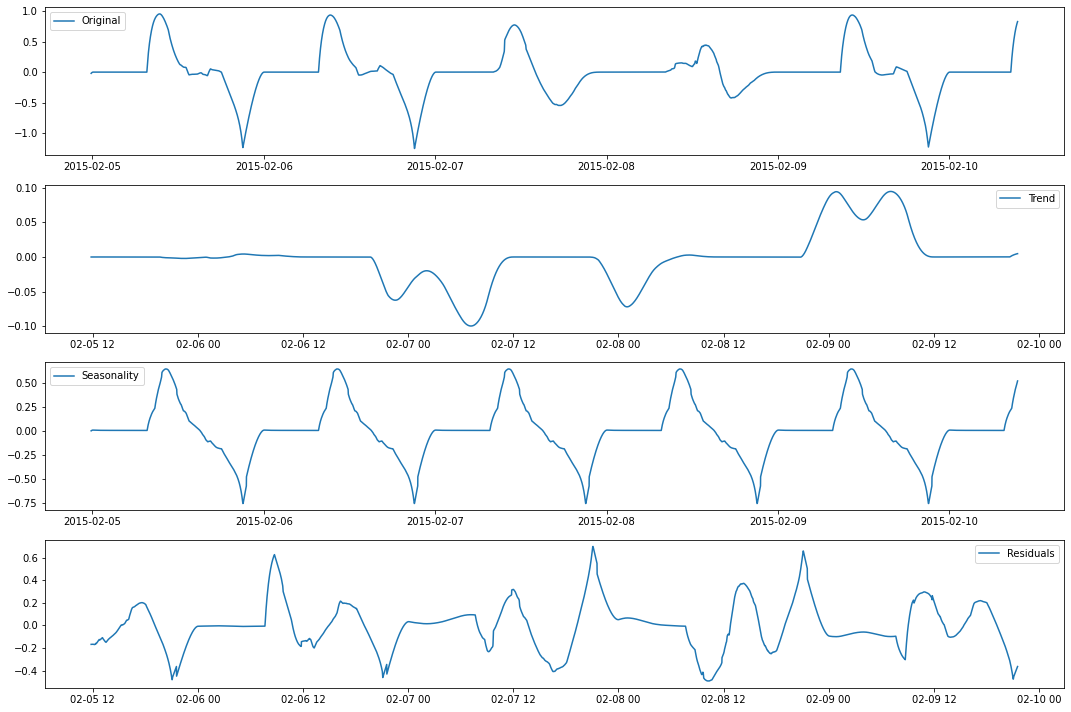

In [0]:
decomposition = sm.tsa.seasonal_decompose(ts_log_mov_diff[179:],freq= 1440)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize =(15,10))
plt.subplot(411)
plt.plot(ts_log_mov_diff[179:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Forecasting

In [0]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [0]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

In [0]:
ts

2015-02-04 20:50:00   -0.421368
2015-02-04 20:51:00   -0.433520
2015-02-04 20:52:00   -0.445772
2015-02-04 20:53:00   -0.457924
2015-02-04 20:54:00   -0.470075
                         ...   
2015-02-10 09:29:00    0.018333
2015-02-10 09:30:00    0.030685
2015-02-10 09:31:00    0.043036
2015-02-10 09:32:00    0.055388
2015-02-10 09:33:00    0.068139
Freq: T, Length: 7964, dtype: float64

In [0]:
index_test = pd.date_range(start=ts_test.index[179], end=ts_test.index[len(ts_test)-1], freq='T')
ts_test = pd.Series(ts_test.values[179:],index_test)
ts_test

2015-02-11 17:47:00    1.479459
2015-02-11 17:48:00    1.478969
2015-02-11 17:49:00    1.478480
2015-02-11 17:50:00    1.478080
2015-02-11 17:51:00    1.477546
                         ...   
2015-02-18 09:15:00   -0.517473
2015-02-18 09:16:00   -0.506174
2015-02-18 09:17:00   -0.494874
2015-02-18 09:18:00   -0.483702
2015-02-18 09:19:00   -0.472789
Freq: T, Length: 9573, dtype: float64

In [0]:
total_ts = ts.append(ts_test)
total_ts.isnull().sum()

0

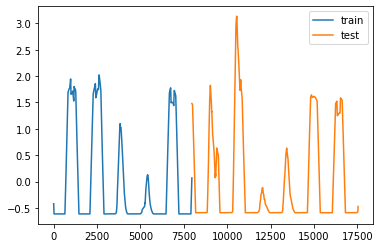

In [0]:
plt.plot(range(len(index)), ts, label='train')
plt.plot(range(len(index),len(index)+len(index_test)), ts_test, label='test')
plt.legend()
plt.show()


In [0]:
ts_diff_test = pd.Series(ts_test[:-6].values - ts_test[6:].values, index=ts_test.index[6:])
ts_diff_test

total_ts_diff = ts_diff.append(ts_diff_test)
total_ts_diff.isnull().sum()

0

In [0]:
ts_log_test = pd.Series(np.log(ts_test.values+1), index_test)
ts_log_mov_diff_test = pd.Series(ts_log_test - ts_log_test.rolling(window, center=False).mean(), index=ts_log_test.index)
ts_log_mov_diff_test

2015-02-11 17:47:00         NaN
2015-02-11 17:48:00         NaN
2015-02-11 17:49:00         NaN
2015-02-11 17:50:00         NaN
2015-02-11 17:51:00         NaN
                         ...   
2015-02-18 09:15:00    0.154423
2015-02-18 09:16:00    0.176522
2015-02-18 09:17:00    0.197972
2015-02-18 09:18:00    0.218555
2015-02-18 09:19:00    0.238060
Freq: T, Length: 9573, dtype: float64

In [0]:
total_ts_log = ts_log.append(ts_log_test)
total_ts_log.isnull().sum()

0

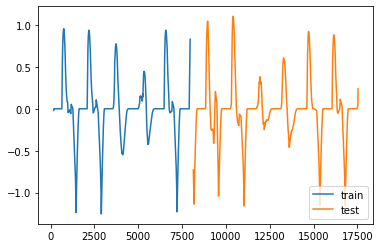

In [0]:
plt.plot(range(len(ts_log_mov_diff)), ts_log_mov_diff, label='train')
plt.plot(range(len(ts_log_mov_diff), len(ts_log_mov_diff)+len(ts_log_mov_diff_test)), ts_log_mov_diff_test, label='test')
plt.legend()
plt.show()

In [0]:
total_log_diff = ts_log_mov_diff[179:].append(ts_log_mov_diff[179:])
total_log_diff.isnull().sum()

0

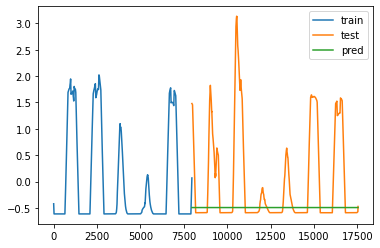

AIC -8966.148
MAE 0.590
RMSE 1.004
MAD 0.098
R2 -0.300
MAPE 1.197
MAXAPE 7.357
TAPE 11459.121


In [0]:
smoothing_level = 0.005

ses = SimpleExpSmoothing(ts).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=ts_test.index[0], end=ts_test.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts), len(ts)+len(ts_test)), ts_test, label='test')
plt.plot(range(len(ts), len(ts)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(ses.aic,3))

for k, v in evaluate(ts_test, pred, total_ts).items():
    print('%s %.3f' % (k, v))

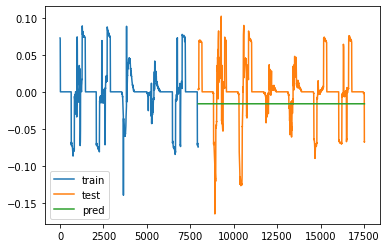

AIC -56978.171
MAE 0.029
RMSE 0.039
MAD 0.016
R2 -0.252
MAPE 1.821
MAXAPE 9.207
TAPE 17418.231


In [0]:
smoothing_level = 0.005

ses = SimpleExpSmoothing(ts_diff).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=ts_diff_test.index[0], end=ts_diff_test.index[-1])

plt.plot(range(len(ts_diff)), ts_diff, label='train')
plt.plot(range(len(ts_diff), len(ts_diff)+len(ts_diff_test)), ts_diff_test, label='test')
plt.plot(range(len(ts_diff), len(ts_diff)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(ses.aic,3))

for k, v in evaluate(ts_diff_test, pred, total_ts_diff).items():
    print('%s %.3f' % (k, v))

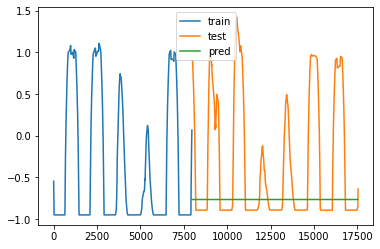

AIC -10638.104
MAE 0.577
RMSE 0.865
MAD 0.128
R2 -0.349
MAPE 0.753
MAXAPE 2.852
TAPE 7212.761


In [0]:
smoothing_level = 0.005

ses = SimpleExpSmoothing(ts_log).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=ts_log_test.index[0], end=ts_log_test.index[-1])

plt.plot(range(len(ts_log)), ts_log, label='train')
plt.plot(range(len(ts_log), len(ts_log)+len(ts_log_test)), ts_log_test, label='test')
plt.plot(range(len(ts_log), len(ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(ses.aic,3))

for k, v in evaluate(ts_log_test, pred, total_ts_log).items():
    print('%s %.3f' % (k, v))

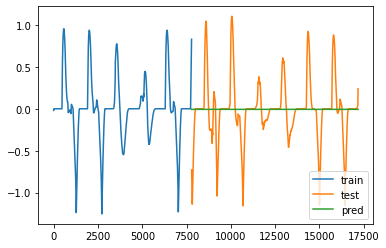

AIC -16106.163
MAE 0.204
RMSE 0.355
MAD 0.043
R2 0.002
MAPE 29.644
MAXAPE 166.952
TAPE 278478.851


In [0]:
smoothing_level = 0.0005

ses = SimpleExpSmoothing(ts_log_mov_diff[179:]).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=ts_log_mov_diff_test.index[179], end=ts_log_mov_diff_test.index[-1])

plt.plot(range(len(ts_log_mov_diff[179:])), ts_log_mov_diff[179:], label='train')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(ts_log_mov_diff_test[179:])), ts_log_mov_diff_test[179:], label='test')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(ses.aic,3))

for k, v in evaluate(ts_log_mov_diff_test[179:], pred, total_log_diff).items():
    print('%s %.3f' % (k, v))

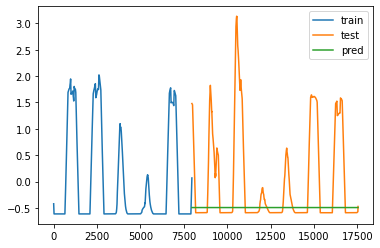

AIC -8962.148
MAE 0.590
RMSE 1.004
MAD 0.098
R2 -0.300
MAPE 1.197
MAXAPE 7.357
TAPE 11459.121


In [0]:
smoothing_level=0.005

holt = Holt(ts).fit(smoothing_level=smoothing_level)
pred = holt.predict(start=ts_test.index[0], end=ts_test.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts), len(ts)+len(ts_test)), ts_test, label='test')
plt.plot(range(len(ts), len(ts)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(holt.aic,3))

for k, v in evaluate(ts_test, pred, total_ts).items():
    print('%s %.3f' % (k, v))

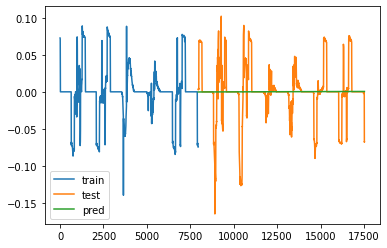

AIC -54490.366
MAE 0.018
RMSE 0.035
MAD 0.001
R2 -0.001
MAPE 1171.456
MAXAPE 2084635.785
TAPE 11207318.336


In [0]:
smoothing_level=0.0005

holt = Holt(ts_diff).fit(smoothing_level=smoothing_level)
pred = holt.predict(start=ts_diff_test.index[0], end=ts_diff_test.index[-1])

plt.plot(range(len(ts_diff)), ts_diff, label='train')
plt.plot(range(len(ts_diff), len(ts_diff)+len(ts_diff_test)), ts_diff_test, label='test')
plt.plot(range(len(ts_diff), len(ts_diff)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(holt.aic,3))

for k, v in evaluate(ts_diff_test, pred, total_ts_diff).items():
    print('%s %.3f' % (k, v))

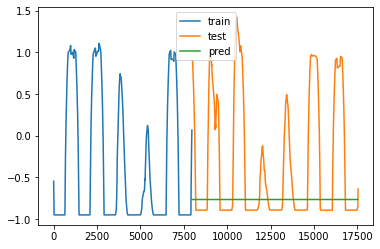

AIC -10634.104
MAE 0.577
RMSE 0.865
MAD 0.128
R2 -0.349
MAPE 0.753
MAXAPE 2.852
TAPE 7212.761


In [0]:
smoothing_level=0.005

holt = Holt(ts_log).fit(smoothing_level=smoothing_level)
pred = holt.predict(start=ts_log_test.index[0], end=ts_log_test.index[-1])

plt.plot(range(len(ts_log)), ts_log, label='train')
plt.plot(range(len(ts_log), len(ts_log)+len(ts_log_test)), ts_log_test, label='test')
plt.plot(range(len(ts_log), len(ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(holt.aic,3))

for k, v in evaluate(ts_log_test, pred, total_ts_log).items():
    print('%s %.3f' % (k, v))

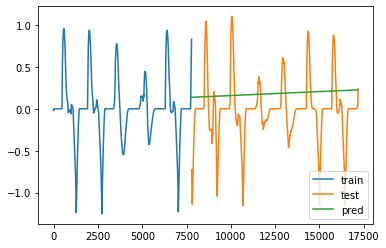

AIC -19598.128
MAE 0.318
RMSE 0.404
MAD 0.211
R2 -0.298
MAPE 1.797
MAXAPE 9.298
TAPE 16880.850


In [0]:
smoothing_level=0.005

holt = Holt(ts_log_mov_diff[179:]).fit(smoothing_level=smoothing_level)
pred = holt.predict(start=ts_log_mov_diff_test.index[179], end=ts_log_mov_diff_test.index[-1])

plt.plot(range(len(ts_log_mov_diff[179:])), ts_log_mov_diff[179:], label='train')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(ts_log_mov_diff_test[179:])), ts_log_mov_diff_test[179:], label='test')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(holt.aic,3))

for k, v in evaluate(ts_log_mov_diff_test[179:], pred, total_log_diff).items():
    print('%s %.3f' % (k, v))

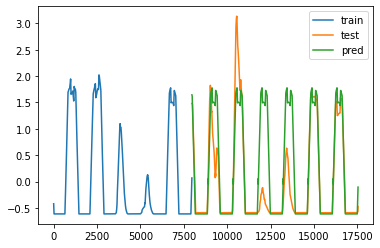

AIC -2733.536
MAE 0.320
RMSE 0.640
MAD 0.023
R2 0.471
MAPE 0.765
MAXAPE 532.537
TAPE 7326.080


In [0]:
seasonal_periods=1440

es = ExponentialSmoothing(ts, seasonal_periods=seasonal_periods, seasonal='add').fit(smoothing_seasonal=1.0)
pred = es.predict(start=ts_test.index[0], end=ts_test.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts), len(ts)+len(ts_test)), ts_test, label='test')
plt.plot(range(len(ts), len(ts)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(es.aic,3))

for k, v in evaluate(ts_test, pred, total_ts).items():
    print('%s %.3f' % (k, v))

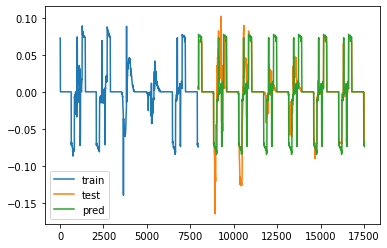

AIC -54026.46
MAE 0.014
RMSE 0.027
MAD 0.001
R2 0.400
MAPE inf
MAXAPE inf
TAPE inf


In [0]:
seasonal_periods=1440

es = ExponentialSmoothing(ts_diff, seasonal_periods=seasonal_periods, seasonal='add').fit(smoothing_seasonal=1.0)
pred = es.predict(start=ts_diff_test.index[0], end=ts_diff_test.index[-1])

plt.plot(range(len(ts_diff)), ts_diff, label='train')
plt.plot(range(len(ts_diff), len(ts_diff)+len(ts_diff_test)), ts_diff_test, label='test')
plt.plot(range(len(ts_diff), len(ts_diff)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(es.aic,3))

for k, v in evaluate(ts_diff_test, pred, total_ts_diff).items():
    print('%s %.3f' % (k, v))

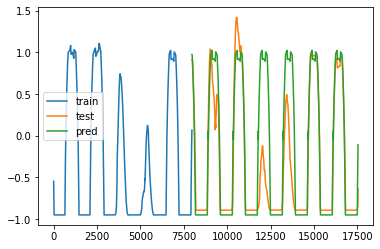

AIC -5273.619
MAE 0.241
RMSE 0.460
MAD 0.057
R2 0.618
MAPE 0.951
MAXAPE 799.674
TAPE 9107.056


In [0]:
seasonal_periods=1440

es = ExponentialSmoothing(ts_log, seasonal_periods=seasonal_periods, seasonal='add').fit(smoothing_seasonal=1.0)
pred = es.predict(start=ts_log_test.index[0], end=ts_log_test.index[-1])

plt.plot(range(len(ts_log)), ts_log, label='train')
plt.plot(range(len(ts_log), len(ts_log)+len(ts_log_test)), ts_log_test, label='test')
plt.plot(range(len(ts_log), len(ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(es.aic,3))

for k, v in evaluate(ts_log_test, pred, total_ts_log).items():
    print('%s %.3f' % (k, v))

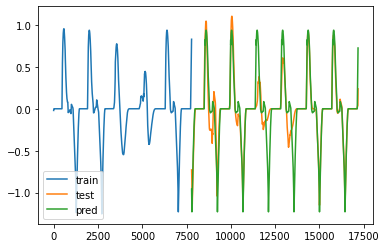

AIC -17516.165
MAE 0.106
RMSE 0.211
MAD 0.025
R2 0.647
MAPE 88605418399.854
MAXAPE 55880503451920.891
TAPE 832359300448262.250


In [0]:
seasonal_periods=1440

es = ExponentialSmoothing(ts_log_mov_diff[179:], seasonal_periods=seasonal_periods, seasonal='add').fit(smoothing_seasonal=1.0)
pred = es.predict(start=ts_log_mov_diff_test.index[179], end=ts_log_mov_diff_test.index[-1])

plt.plot(range(len(ts_log_mov_diff[179:])), ts_log_mov_diff[179:], label='train')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(ts_log_mov_diff_test[179:])), ts_log_mov_diff_test[179:], label='test')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(es.aic,3))

for k, v in evaluate(ts_log_mov_diff_test[179:], pred, total_log_diff).items():
    print('%s %.3f' % (k, v))

Optimization terminated successfully.
         Current function value: -5.644759
         Iterations 2


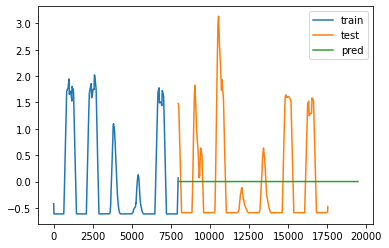

AIC -89881.139
MAE 0.728
RMSE 0.880
MAD 0.591
R2 -0.000
MAPE 231811.823
MAXAPE 998739.739
TAPE 2219134583.305


In [0]:
arima = ARIMA(ts, order=(0,2,1)).fit(solver='newton')
pred = arima.predict(start=ts.index[-1], end=ts_test.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts), len(ts)+len(ts_test)), ts_test, label='test')
plt.plot(range(len(ts), len(ts)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(arima.aic,3))

for k, v in evaluate(ts_test, pred[1934:], total_ts).items():
    print('%s %.3f' % (k, v))

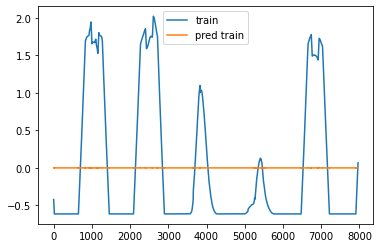

MAE 0.767
RMSE 0.899
MAD 0.614
R2 -0.000
MAPE 267512.570
MAXAPE 506184383.349
TAPE 2129935082.800


In [0]:
pred_train = arima.predict(start=ts.index[2], end=ts.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts[2:])), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(ts[2:], pred_train, ts).items():
    print('%s %.3f' % (k, v))

Optimization terminated successfully.
         Current function value: -5.182357
         Iterations 4


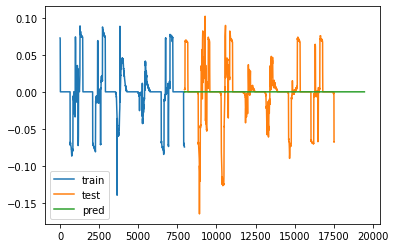

AIC -82466.023
MAE 0.018
RMSE 0.035
MAD 0.001
R2 -0.001
MAPE 969.340
MAXAPE 8852.458
TAPE 9273675.715


In [0]:
arima = ARIMA(ts_diff, order=(0,1,1)).fit(solver='newton')
pred = arima.predict(start=ts_diff.index[-1], end=ts_diff_test.index[-1])

plt.plot(range(len(ts_diff)), ts_diff, label='train')
plt.plot(range(len(ts_diff), len(ts_diff)+len(ts_diff_test)), ts_diff_test, label='test')
plt.plot(range(len(ts_diff), len(ts_diff)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(arima.aic,3))

for k, v in evaluate(ts_diff_test, pred[1940:], total_ts_diff).items():
    print('%s %.3f' % (k, v))

Optimization terminated successfully.
         Current function value: -5.384298
         Iterations 2


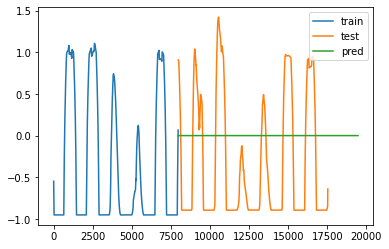

AIC -85733.562
MAE 0.769
RMSE 0.813
MAD 0.894
R2 -0.192
MAPE 184769.431
MAXAPE 341023.621
TAPE 1768797761.664


In [0]:
arima = ARIMA(ts_log, order=(0,2,1)).fit(solver='newton')
pred = arima.predict(start=ts_log.index[-1], end=ts_log_test.index[-1])

plt.plot(range(len(ts_log)), ts_log, label='train')
plt.plot(range(len(ts_log), len(ts_log)+len(ts_log_test)), ts_log_test, label='test')
plt.plot(range(len(ts_log), len(ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(arima.aic,3))

for k, v in evaluate(ts_log_test, pred[1934:], total_ts_log).items():
    print('%s %.3f' % (k, v))

Optimization terminated successfully.
         Current function value: -5.432859
         Iterations 2


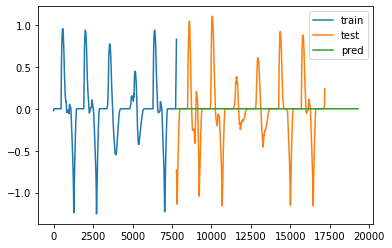

AIC -84561.876
MAE 0.203
RMSE 0.355
MAD 0.045
R2 0.001
MAPE 378869.150
MAXAPE 2167113.114
TAPE 3559096792.182


In [0]:
arima = ARIMA(ts_log_mov_diff[179:], order=(0,2,1)).fit(solver='newton')
pred = arima.predict(start=ts_log_mov_diff.index[-1], end=ts_log_mov_diff_test.index[-1])

plt.plot(range(len(ts_log_mov_diff[179:])), ts_log_mov_diff[179:], label='train')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(ts_log_mov_diff_test[179:])), ts_log_mov_diff_test[179:], label='test')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(arima.aic,3))

for k, v in evaluate(ts_log_mov_diff_test[179:], pred[2113:], total_log_diff).items():
    print('%s %.3f' % (k, v))
    

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


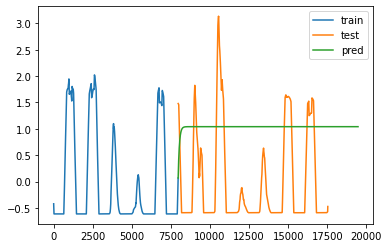

AIC -90100.232
MAE 1.271
RMSE 1.371
MAD 1.632
R2 -1.425
MAPE 1.221
MAXAPE 2.012
TAPE 11692.833


In [0]:
sarimax = SARIMAX(ts, order=(0,1,1), seasonal_order=(24, 0, 1, 1)).fit(disp=False)
pred = sarimax.predict(start=ts.index[-1], end=ts_test.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts), len(ts)+len(ts_test)), ts_test, label='test')
plt.plot(range(len(ts), len(ts)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(sarimax.aic,3))

for k, v in evaluate(ts_test, pred[1934:], total_ts).items():
    print('%s %.3f' % (k, v))

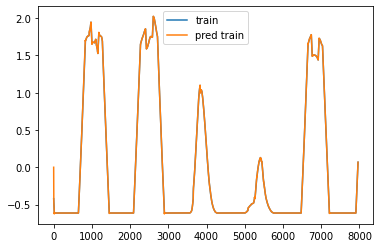

MAE 0.000
RMSE 0.005
MAD 0.000
R2 1.000
MAPE inf
MAXAPE inf
TAPE inf


In [0]:
pred_train = sarimax.predict(start=ts.index[0], end=ts.index[-1])

plt.plot(range(len(ts)), ts, label='train')
plt.plot(range(len(ts)), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(ts, pred_train, ts).items():
    print('%s %.3f' % (k, v))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


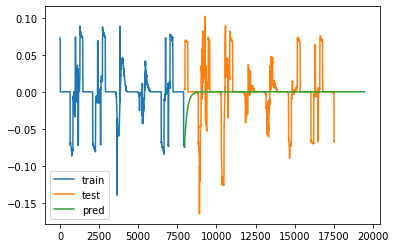

AIC -88807.586
MAE 0.018
RMSE 0.035
MAD 0.001
R2 -0.001
MAPE 211738627767733536845463552.000
MAXAPE 217363725245191257974779150336.000
TAPE 2025703451853906056369808605184.000


In [0]:
sarimax = SARIMAX(ts_diff, order=(0,0,1), seasonal_order=(24, 0, 0, 1)).fit(disp=False)
pred = sarimax.predict(start=ts_diff.index[-1], end=ts_diff_test.index[-1])

plt.plot(range(len(ts_diff)), ts_diff, label='train')
plt.plot(range(len(ts_diff), len(ts_diff)+len(ts_diff_test)), ts_diff_test, label='test')
plt.plot(range(len(ts_diff), len(ts_diff)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(sarimax.aic,3))

for k, v in evaluate(ts_diff_test, pred[1940:], total_ts_diff).items():
    print('%s %.3f' % (k, v))

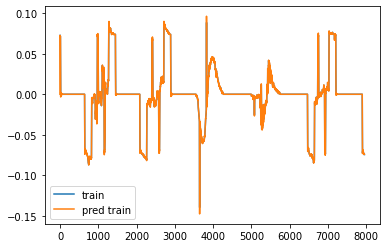

MAE 0.000
RMSE 0.001
MAD 0.000
R2 0.999
MAPE inf
MAXAPE inf
TAPE inf


In [0]:
pred_train = sarimax.predict(start=ts_diff.index[0], end=ts_diff.index[-1])

plt.plot(range(len(ts_diff)), ts_diff, label='train')
plt.plot(range(len(ts_diff)), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(ts_diff, pred_train, ts_diff).items():
    print('%s %.3f' % (k, v))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


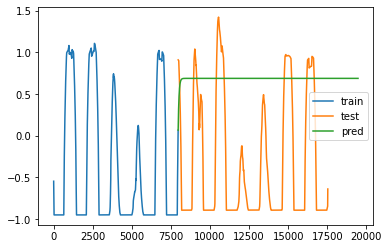

AIC -85943.452
MAE 1.112
RMSE 1.257
MAD 1.576
R2 -1.849
MAPE 1.620
MAXAPE 2.303
TAPE 15504.381


In [0]:
sarimax = SARIMAX(ts_log, order=(0,1,1), seasonal_order=(24, 0, 1, 1)).fit(disp=False)
pred = sarimax.predict(start=ts_log.index[-1], end=ts_log_test.index[-1])

plt.plot(range(len(ts_log)), ts_log, label='train')
plt.plot(range(len(ts_log), len(ts_log)+len(ts_log_test)), ts_log_test, label='test')
plt.plot(range(len(ts_log), len(ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(sarimax.aic,3))

for k, v in evaluate(ts_log_test, pred[1934:], total_ts_log).items():
    print('%s %.3f' % (k, v))

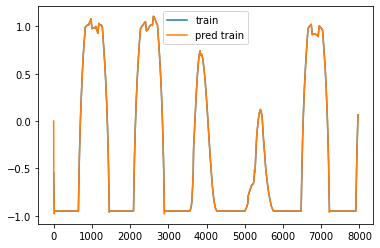

MAE 0.000
RMSE 0.006
MAD 0.000
R2 1.000
MAPE inf
MAXAPE inf
TAPE inf


In [0]:
pred_train = sarimax.predict(start=ts_log.index[0], end=ts_log.index[-1])

plt.plot(range(len(ts_log)), ts_log, label='train')
plt.plot(range(len(ts_log)), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(ts_log, pred_train, ts_log).items():
    print('%s %.3f' % (k, v))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


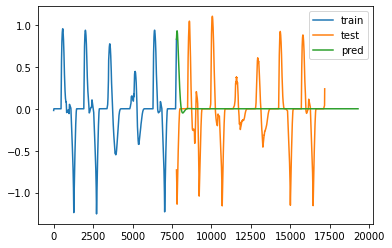

AIC -84997.812
MAE 0.203
RMSE 0.355
MAD 0.045
R2 0.001
MAPE 48531461554594079881978271694751531008.000
MAXAPE 83795383623327585716955159348212563705856.000
TAPE 455904549843857247994293385911097649790976.000


In [0]:
sarimax = SARIMAX(ts_log_mov_diff[179:], order=(0,0,1), seasonal_order=(24, 0, 0, 1)).fit(disp=False)
pred = sarimax.predict(start=ts_log_mov_diff.index[-1], end=ts_log_mov_diff_test.index[-1])

plt.plot(range(len(ts_log_mov_diff[179:])), ts_log_mov_diff[179:], label='train')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(ts_log_mov_diff_test[179:])), ts_log_mov_diff_test[179:], label='test')
plt.plot(range(len(ts_log_mov_diff[179:]), len(ts_log_mov_diff[179:])+len(pred)), pred, label='pred')
plt.legend()
plt.show()
print("AIC",round(sarimax.aic,3))

for k, v in evaluate(ts_log_mov_diff_test[179:], pred[2113:], total_log_diff).items():
    print('%s %.3f' % (k, v))

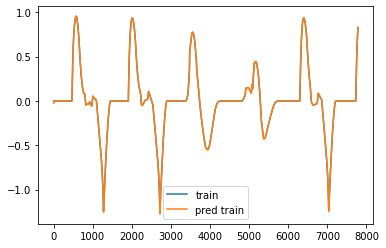

MAE 0.000
RMSE 0.001
MAD 0.000
R2 1.000
MAPE inf
MAXAPE inf
TAPE inf


In [0]:
pred_train = sarimax.predict(start=ts_log_mov_diff.index[179], end=ts_log_mov_diff.index[-1])

plt.plot(range(len(ts_log_mov_diff[179:])), ts_log_mov_diff[179:], label='train')
plt.plot(range(len(ts_log_mov_diff[179:])), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(ts_log_mov_diff[179:], pred_train, ts_log_mov_diff[179:]).items():
    print('%s %.3f' % (k, v))